# EDA which makes sense ⭐️⭐️⭐️⭐️⭐️

This notebook shows an exploratory data analysis for the November 2022 Tabular Playground competition.

In [1]:
import glob, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss

# Reading the data

The members of our ensemble are given as 5000 submission files. Every submission file contains 40000 predictions. We read all of this data into an array `X`.

We save `X` as a pickle file. If you load it from this notebook's output, you can save some time:

```
with open('../input/tpsnov22-eda-which-makes-sense/X.pickle', 'rb') as f: X = pickle.load(f)
```

In [2]:
%%time
X = np.zeros((40000, 5000))
names = sorted(glob.glob('../input/tabular-playground-series-nov-2022/submission_files/*.csv'))
for i, name in enumerate(names):
    assert len(name) == 77
    sub = pd.read_csv(name)
    assert (sub.id == np.arange(40000)).all()
    if i == 0: 
        print('Sample input file:')
        display(sub)
    X[:,i] = sub.pred.values
    if i % 1000 == 0: print(i)
with open('X.pickle', 'wb') as f: pickle.dump(X, f)
    
X_dev = X[:20000]
X_test = X[20000:]


Sample input file:


,id,pred
0,0,0.709336
1,1,0.452988
2,2,0.675462
3,3,0.481046
4,4,0.957339
...,...,...
39995,39995,0.382515
39996,39996,0.352498
39997,39997,0.577554
39998,39998,0.712353


0
1000
2000
3000
4000
CPU times: user 59.8 s, sys: 21 s, total: 1min 20s
Wall time: 2min 32s


The first half of the data (i.e. 20000 of the 40000 rows) are labeled. We read these labels into an array `y`.

In [3]:
y = pd.read_csv('../input/tabular-playground-series-nov-2022/train_labels.csv')
assert (y.id == np.arange(20000)).all()
display(y)
y = y.label.values

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
19995,19995,1
19996,19996,1
19997,19997,0
19998,19998,0


The classification problem is balanced: There are 50 % positive and 50 % negative samples:

In [4]:
y.mean()

0.5

# Outliers and null values

Let's do a sanity check:
- The predictions should be probabilities between 0 and 1, but X contains some values outside this range.
- The labels are all 0 or 1, as is to be expected.
- There are no null values.

**Insight:** We should clean the data before we start ensembling. We can drop columns which contain outliers, drop training rows which contain outliers, or we can simply clip the data to the interval [0, 1].

In [5]:
print('Minimum and maximum X values:', X.min(), X.max())
print('Unique labels:               ', np.unique(y))
print('Null values in X and y:      ', np.isnan(X).sum(), np.isnan(y).sum())

Minimum and maximum X values: -0.376186 1.356611
Unique labels:                [0 1]
Null values in X and y:       0 0


We count the outliers:

In [6]:
print(f"Values below zero:           {(X < 0).sum()}")
print(f"Values above one:           {(X > 1).sum()}")
print(f"Rows containing outliers:    {((X < 0) | (X > 1)).any(axis=1).sum()} of {X.shape[0]}")
print(f"Columns containing outliers:  {((X < 0) | (X > 1)).any(axis=0).sum()} of {X.shape[1]}")


Values below zero:           1967
Values above one:           15592
Rows containing outliers:    3606 of 40000
Columns containing outliers:  108 of 5000


# Duplicates

We check for duplicate rows or columns in the data. There are no duplicates.

In [7]:
print(np.unique(X, axis=0).shape)
print(np.unique(X, axis=1).shape)


(40000, 5000)
(40000, 5000)


# File names and log loss

According to the data description, the 5000 file names correspond to the log loss of the file. We verify this claim:

In [8]:
print('name                          log loss')
for sub in range(5):
    name_loss = float(names[sub][61:-4])
    print(names[sub][61:], name_loss, log_loss(y, X_dev[:,sub]))
    
log_loss_list = []
for sub in range(X.shape[1]):
    name_loss = float(names[sub][61:-4])
    log_loss_list.append(name_loss)
    assert abs(name_loss - log_loss(y, X_dev[:,sub])) < 1e-10
    

name                          log loss
0.6222863195.csv 0.6222863195 0.6222863195129075
0.6223807245.csv 0.6223807245 0.6223807245068153
0.6225426578.csv 0.6225426578 0.622542657774157
0.6247722291.csv 0.6247722291 0.6247722290993437
0.6253455681.csv 0.6253455681 0.6253455680841075


The histogram of the 5000 scores shows that all models have loglosses between 0.622 and 0.758. Did you notice that these scores are rather weak? A dummy model which predicts 0.5 all the time has a log loss of 0.693 (red line in the diagram). A perfect model would have a log loss of 0.

**Insight:** Half the input models are worse than a dummy classifier! Should we drop these columns immediately? No. Although these columns have high logloss, they still contain information which can be valuable to an ensemble.

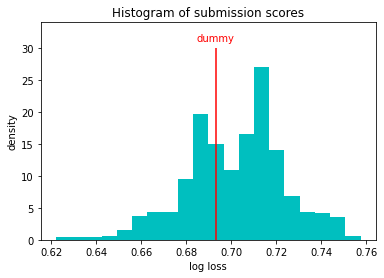

In [9]:
plt.hist(log_loss_list, bins=20, density=True, color='c')
plt.vlines([log_loss(y, np.full(len(y), 0.5))], 0, 30, color='r')
plt.text(0.693, 31, 'dummy', color='r', ha='center')
plt.title('Histogram of submission scores')
plt.xlabel('log loss')
plt.ylabel('density')
plt.ylim(0, 34)
plt.show()

While we are computing loglosses, we can check if any classifier is so bad that inverting its predictions improves the logloss, and in fact, there are nine such classifiers:

In [10]:
for sub in range(X.shape[1]):
    if log_loss(y, X_dev[:,sub]) > log_loss(y, 1 - X_dev[:,sub]):
        print(f'Inverting improves column {sub} from {log_loss(y, X_dev[:,sub]):.4f} to {log_loss(y, 1 - X_dev[:,sub]):.4f}')


Inverting improves column 1818 from 0.6933 to 0.6933
Inverting improves column 1953 from 0.6953 to 0.6915
Inverting improves column 2009 from 0.6962 to 0.6937
Inverting improves column 2126 from 0.6982 to 0.6980
Inverting improves column 2575 from 0.7069 to 0.6937
Inverting improves column 3851 from 0.7168 to 0.7138
Inverting improves column 4213 from 0.7215 to 0.7213
Inverting improves column 4708 from 0.7367 to 0.7355
Inverting improves column 4882 from 0.7450 to 0.7388


# Feature histograms and calibration

Plotting the histograms of a few submissions, we see diverse shapes. Many of the histograms are heavier on the right side, i.e., the models often predict probabilities above 0.5, which is strange for a balanced classification problem.

**Insight:**
- We somehow have to deal with the diversity of the distributions. An underconfident model (e.g., number 917) should get a higher weight in the ensemble than a more confident model (e.g., number 0).
- Rank ensembling is an option.
- Maybe we can improve the logloss by transforming the imbalanced predictions to make them more balanced.
- Maybe the word "ensemble" in the competition description has been put there only as a distraction. It will be advantageous if we think of this competition as a standard binary classification problem with 5000 features. We can use any classification model and should not focus on the models which are usually used in ensembling. Of course we need a model which can predict probabilities (e.g., `LogisticRegression` has a `predict_proba` function, `RidgeClassifier` hasn't).

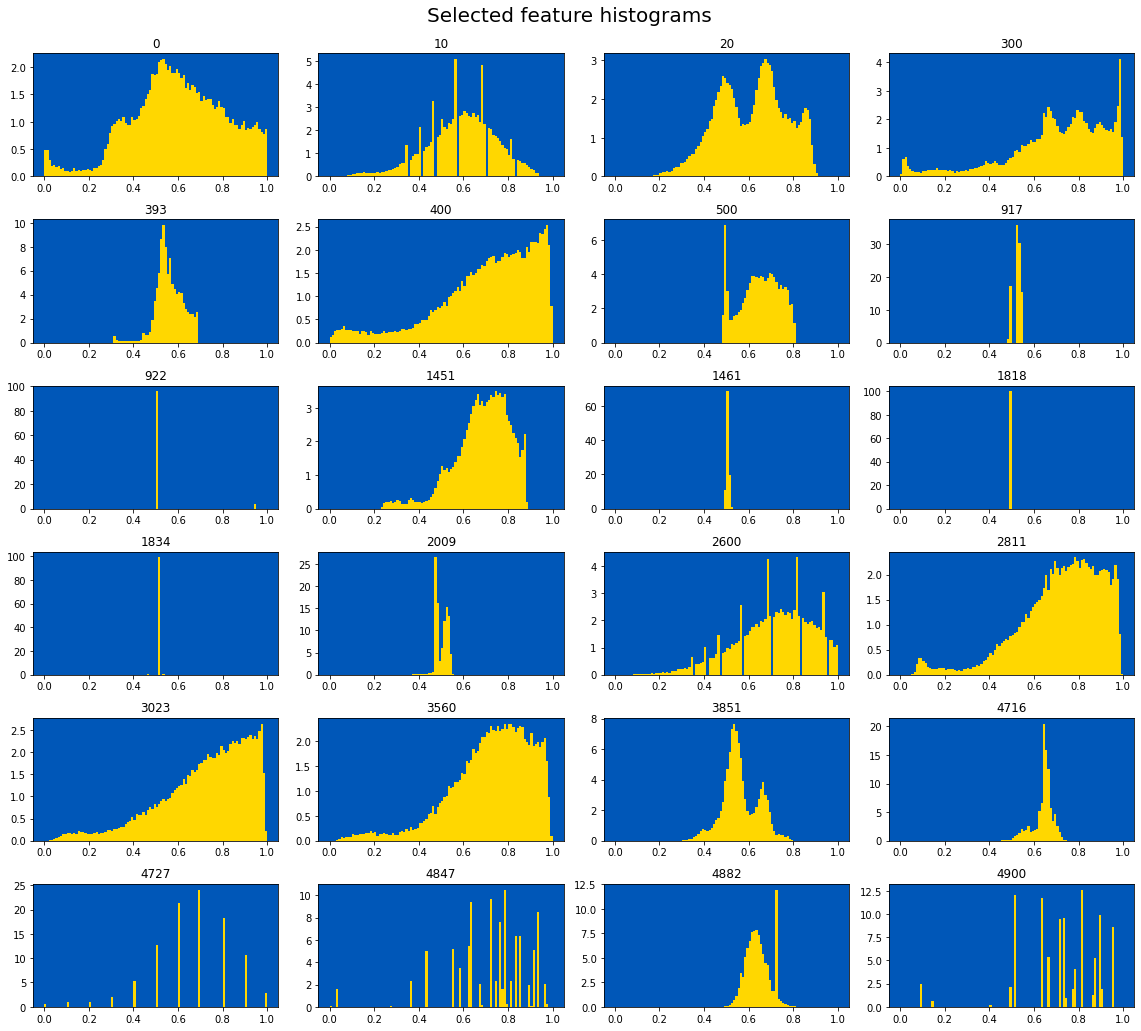

In [11]:
sample_subs = [0, 10, 20, 300, 393, 400, 500, 917,
               922, 1451, 1461, 1818, 1834, 2009, 2600, 2811,
               3023, 3560, 3851, 4716, 4727, 4847, 4882, 4900]
_, axs = plt.subplots(6, 4, figsize=(16, 14))
axs = axs.ravel()
for i, sub in enumerate(sample_subs):
    axs[i].hist(X[:,sub], range=(0, 1), bins=100, density=True, color='#ffd700')
    axs[i].set_title(f"{sub}")
    axs[i].set_facecolor('#0057b8') # blue
plt.tight_layout(h_pad=1.0)
plt.suptitle('Selected feature histograms', y=1.02, fontsize=20)
plt.show()

The [calibration curve](https://scikit-learn.org/stable/modules/calibration.html) shows how well the predicted probabilities correspond to the true probabilities. The ideal calibration curve is a straight line from (0, 0) to (1, 1), i.e. the black dotted line from bottom left to top right. Number 0 is not bad, except that its predictions are always a little to high. We see that many calibrations are far from ideal. 

**Insight:**
- The calibration curves show that a simple blend (weighted average) of the inputs won't give a high-quality ensemble. We need more sophisticated models.
- Maybe we can calibrate the 5000 classifiers and blend the calibrated probabilities.

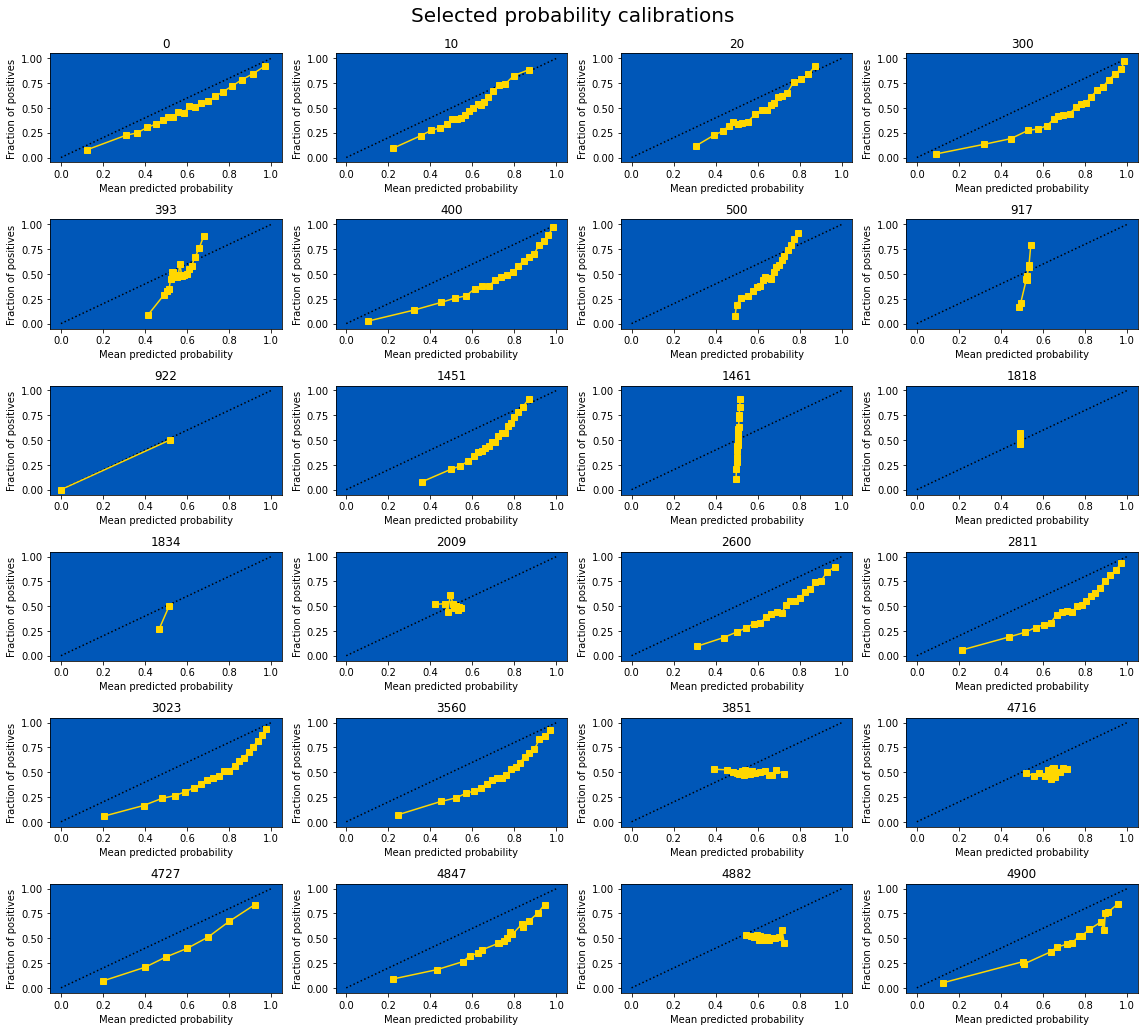

In [12]:
_, axs = plt.subplots(6, 4, figsize=(16, 14))
axs = axs.ravel()
for i, sub in enumerate(sample_subs):
    CalibrationDisplay.from_predictions(y, X_dev[:,sub].clip(0, 1), n_bins=20,
                                        strategy='quantile', ax=axs[i], color='#ffd700')
    axs[i].set_title(f"{sub}")
    axs[i].set_facecolor('#0057b8') # blue
    axs[i].legend('', frameon=False)
plt.tight_layout(h_pad=1.0)
plt.suptitle('Selected probability calibrations', y=1.02, fontsize=20)
plt.show()

# Principal components analysis

The first PCA component already explains 90 % of the variance of the 5000 models. The first five components explain even 95 %.

**Insight:**
- Most of the 5000 submissions are highly correlated. This was to be expected: When you ensemble good submissions, of course they should all make similar predictions.
- Selecting only a subset of the PCA components can help to reduce the noise in the input.

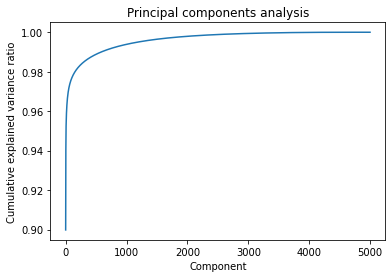

Cumulative explained variance ratio for the first five components: [0.9  0.92 0.93 0.94 0.95]
CPU times: user 13min 7s, sys: 36.2 s, total: 13min 43s
Wall time: 3min 36s


In [13]:
%%time
pca = PCA()
Xt = pca.fit_transform(X)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Principal components analysis')
plt.xlabel('Component')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

print('Cumulative explained variance ratio for the first five components:', pca.explained_variance_ratio_.cumsum()[:5].round(2))


What does "90 % explained variance" mean? A projection of the samples to the first two PCA components shows it: The first component ranges from -20 to 45 and explains 90 % of the total variance. The second component has most of the samples between -5 and 5 and explains only 2½ % of the total variance. The variance grows with the square of the range ($65^2 / 10^2$ is like $90 / 2.5$).

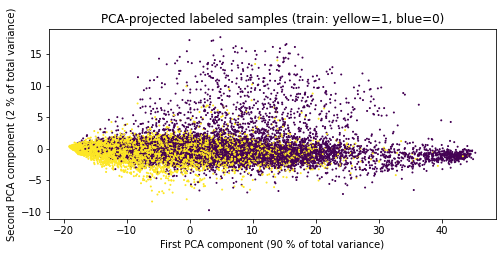

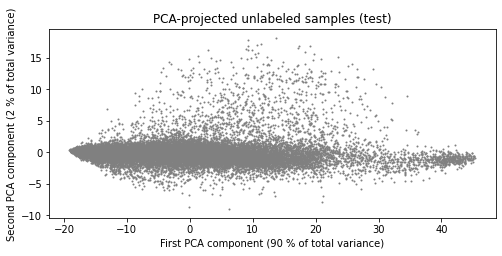

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(Xt[:20000, 0], Xt[:20000, 1], s=1, c=y)
plt.gca().set_aspect('equal')
plt.xlabel('First PCA component (90 % of total variance)')
plt.ylabel('Second PCA component (2 % of total variance)')
plt.title('PCA-projected labeled samples (train: yellow=1, blue=0)')
plt.show()

Xtt = pca.transform(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(Xtt[:20000, 0], Xtt[:20000, 1], s=1, c='gray')
plt.gca().set_aspect('equal')
plt.xlabel('First PCA component (90 % of total variance)')
plt.ylabel('Second PCA component (2 % of total variance)')
plt.title('PCA-projected unlabeled samples (test)')
plt.show()


# Continuous or discrete inputs?

Sometimes we can guess whether an input column is continuous or discrete: If almost all values are different, the column is most likely continuous; if there are only few unique values, the column is discrete. In the present dataset, we have both:

In [15]:
unique_count_list = []
for sub in range(X.shape[1]):
    unique_count = len(np.unique(X[:, sub]))
    unique_count_list.append(unique_count)
unique_counts = pd.Series(unique_count_list, name='unique')
unique_counts.sort_values(inplace=True)
print("Discrete submissions (few unique values):")
print(unique_counts.head(10))
print("Continuous submissions (many unique values):")
print(unique_counts.tail(10))


Discrete submissions (few unique values):
1824     1
1825     1
1148     3
922      3
1834     4
4917     4
917      8
590     11
4727    11
1853    16
Name: unique, dtype: int64
Continuous submissions (many unique values):
4841    39013
320     39018
1       39019
33      39021
1771    39055
30      39075
7       39099
21      39119
22      39151
3       39180
Name: unique, dtype: int64


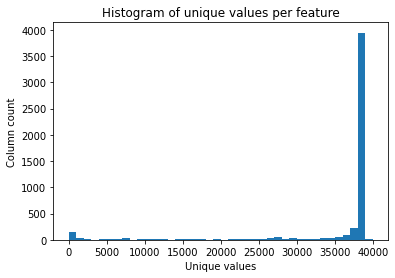

In [16]:
plt.hist(unique_counts, bins=np.linspace(0, 40000, 41))
plt.xlabel('Unique values')
plt.ylabel('Column count')
plt.title('Histogram of unique values per feature')
plt.show()

Some submissions have discrete probabilities at regularly spaced intervals:
- Numbers 590 and 4727 always predict multiples of 1/10.
- Number 1853 predicts multiples of 1/100.
- Number 1814 predicts multiples of 1/200.
- Number 4855 predicts multiples of 1/1000.

There are many more such columns (see the histogram above).


In [17]:
for sub in [590, 4727, 1853, 1814, 4855]:
    values = np.unique(X[:,sub])
    print(f"{Fore.GREEN}{Style.BRIGHT}Column {sub:4} unique values:{Style.RESET_ALL}   {list(values)}")

Column  590 unique values:   [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Column 4727 unique values:   [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Column 1853 unique values:   [0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.79, 0.94, 1.0]
Column 1814 unique values:   [0.385, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47, 0.475, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.565, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.62, 0.625]
Column 4855 unique values:   [0.193, 0.316, 0.318, 0.449, 0.461, 0.586, 0.612, 0.614, 0.671, 0.691, 0.713, 0.733, 0.735, 0.745, 0.779, 0.798, 0.799, 0.8, 0.812, 0.813, 0.814, 0.835, 0.862, 0.872, 0.873, 0.88, 0.885, 0.886, 0.889, 0.915, 0.924, 0.926, 0.934, 0.95, 0.957]


**Insight:**
- We can conjecture that these discrete submissions were produced by a `KNeighborsClassifier` (which counts positive neighbors and divides by the total number of neighbors) or a `VotingClassifier`. Or maybe the predictions were produced by a continuous model and rounded afterwards.
- Can we use this information to produce a better ensemble? I do not yet know...

# Baseline models

We create five baseline models and cross-validate them.
- `LogisticRegression` as an example of a linear classifier
- `KNeighborsClassifier` as an example of a nonparametric, nonlinear classifier
- `ExtraTreesClassifier` as another nonlinear classifier
- the multi-layer perceptron `MLPClassifier`, a simple neural network with one hidden layer
- 'IsotonicRegression' for probability calibration on a single input model

For every model, we plot the prediction histogram and the probability calibration curve. The probability calibration is important because this competition is not about accuracy, but about exactly predicting probabilities.

In [18]:
overall_score_df = pd.DataFrame(columns=['logloss', 'oof'])

def plot_oof_histogram(name, oof, title=None):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.hist(oof, range=(0, 1), bins=100, density=True, color='#ffd700')
    ax1.set_title(f"{name} prediction histogram")
    ax1.set_facecolor('#0057b8') # blue
    
    CalibrationDisplay.from_predictions(y, oof, n_bins=20,
                                        strategy='quantile', ax=ax2, color='#ffd700')
    ax2.set_title('Probability calibration')
    ax2.set_facecolor('#0057b8') # blue
    ax2.legend('', frameon=False)
    if title is not None:
        plt.suptitle(title, y=1.0, fontsize=20)
    plt.show()
    

## LogisticRegression

We chain the logistic regression after a PCA with 50 components. The dimensionality reduction speeds up the regression and reduces the noise.

Fold 0: log_loss = 0.52568
Fold 1: log_loss = 0.54359
Fold 2: log_loss = 0.52953
Fold 3: log_loss = 0.53464
Fold 4: log_loss = 0.52550
Average log_loss:  0.53179


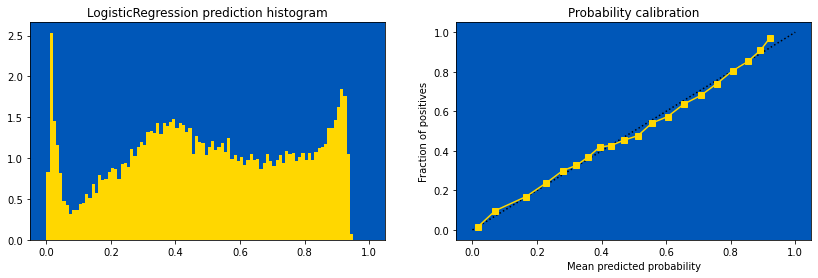

CPU times: user 2min 26s, sys: 26.1 s, total: 2min 52s
Wall time: 54.7 s


In [19]:
%%time
score_list = []
oof = np.zeros((len(X_dev), ))
kf = StratifiedKFold(shuffle=True, random_state=1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
    X_tr = X_dev[idx_tr]
    X_va = X_dev[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = make_pipeline(PCA(n_components=50), LogisticRegression(C=0.1, solver='saga'))
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict_proba(X_va)[:,1]
    logloss = log_loss(y_va, y_va_pred)
    oof[idx_va] = y_va_pred
    print(f"Fold {fold}: log_loss = {logloss:.5f}")
    score_list.append(logloss)
    
print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss:  {sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}') # 0.53180
overall_score_df.loc['LogisticRegression'] = (sum(score_list) / len(score_list), oof)
plot_oof_histogram('LogisticRegression', oof)


## KNeighborsClassifier

`KNeighborsClassifier` needs a substantial number of neighbors to predict probabilities. With `n_neighbors=210`, the histogram contains some artefacts as every predicted probability is a multiple of 1/210.

Fold 0: log_loss = 0.53979
Fold 1: log_loss = 0.55126
Fold 2: log_loss = 0.54057
Fold 3: log_loss = 0.54637
Fold 4: log_loss = 0.54143
Average log_loss:  0.54388


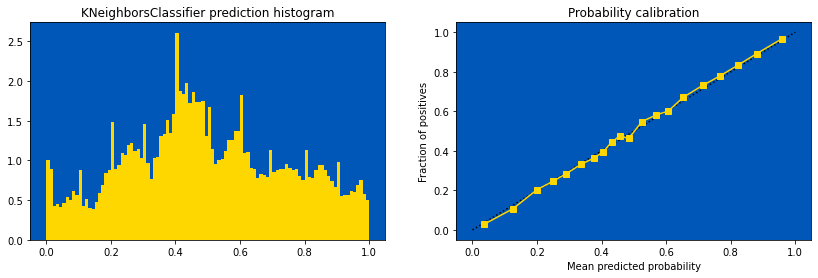

CPU times: user 3min 23s, sys: 6.65 s, total: 3min 30s
Wall time: 1min 1s


In [20]:
%%time
score_list = []
oof = np.zeros((len(X_dev), ))
kf = StratifiedKFold(shuffle=True, random_state=1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
    X_tr = X_dev[idx_tr]
    X_va = X_dev[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = make_pipeline(KNeighborsClassifier(n_neighbors=210))
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict_proba(X_va)[:,1]
    logloss = log_loss(y_va, y_va_pred)
    oof[idx_va] = y_va_pred
    print(f"Fold {fold}: log_loss = {logloss:.5f}")
    score_list.append(logloss)
    
print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss:  {sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}')
overall_score_df.loc['KNeighborsClassifier'] = (sum(score_list) / len(score_list), oof)
plot_oof_histogram('KNeighborsClassifier', oof)


## ExtraTreesClassifier

Our next model is an `ExtraTreesClassifier`. We fit the model twice (with 100 estimators each) with different seeds to get an impression of the variance. The scores of the two instances are different, and this suggests that we increase `n_estimators` to decrease the variance. We can't increase `n_estimators` too much, however, or we get out of memory (the model consists of `n_estimators` trees stored in memory).

Fold 0: log_loss = 0.52758
Fold 1: log_loss = 0.53878
Fold 2: log_loss = 0.53000
Fold 3: log_loss = 0.53151
Fold 4: log_loss = 0.52596
Average log_loss:  0.53076


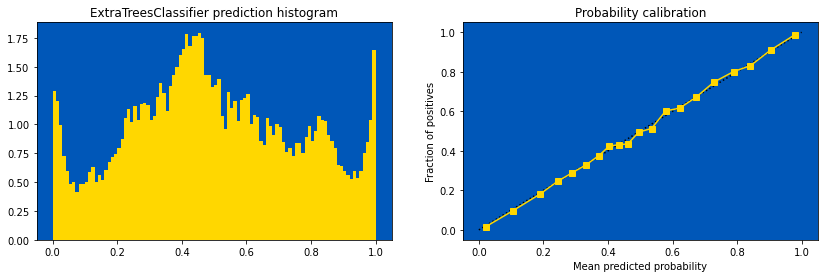

Fold 0: log_loss = 0.52733
Fold 1: log_loss = 0.53948
Fold 2: log_loss = 0.52761
Fold 3: log_loss = 0.52923
Fold 4: log_loss = 0.52540
Average log_loss:  0.52981


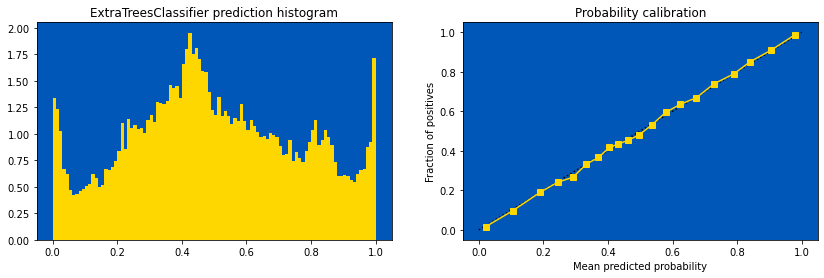

CPU times: user 4min 22s, sys: 2.7 s, total: 4min 25s
Wall time: 4min 25s


In [21]:
%%time
for run in range(2):
    score_list = []
    oof = np.zeros((len(X_dev), ))
    kf = StratifiedKFold(shuffle=True, random_state=1)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
        X_tr = X_dev[idx_tr]
        X_va = X_dev[idx_va]
        y_tr = y[idx_tr]
        y_va = y[idx_va]

        model = make_pipeline(ExtraTreesClassifier(n_estimators=100, min_samples_leaf=12, random_state=run))
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict_proba(X_va)[:,1]
        logloss = log_loss(y_va, y_va_pred)
        oof[idx_va] = y_va_pred
        print(f"Fold {fold}: log_loss = {logloss:.5f}")
        score_list.append(logloss)

    print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss:  {sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}')
    overall_score_df.loc[f'ExtraTreesClassifier {run}'] = (sum(score_list) / len(score_list), oof)
    plot_oof_histogram('ExtraTreesClassifier', oof)


## Multi-layer perceptron

`MLPClassifier` implements a simple neural network in scikit-learn. It has a single hidden layer. If you want more flexibility, choose [Keras](https://keras.io/) or [PyTorch](https://pytorch.org/).

Fold 0: log_loss = 0.52548
Fold 1: log_loss = 0.54032
Fold 2: log_loss = 0.52928
Fold 3: log_loss = 0.53253
Fold 4: log_loss = 0.52456
Average log_loss:  0.53043


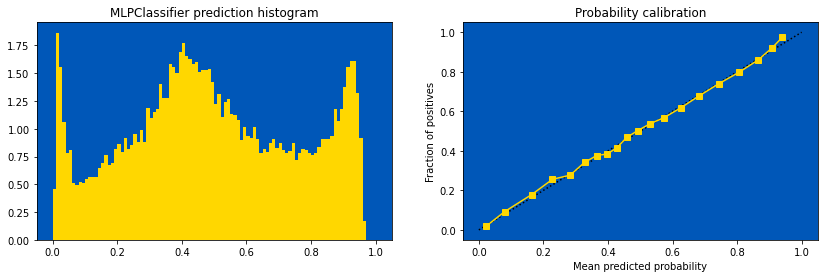

CPU times: user 6min 7s, sys: 2min 51s, total: 8min 59s
Wall time: 2min 22s


In [22]:
%%time
score_list = []
oof = np.zeros((len(X_dev), ))
kf = StratifiedKFold(shuffle=True, random_state=1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
    X_tr = X_dev[idx_tr]
    X_va = X_dev[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = make_pipeline(PCA(80, random_state=1),
                          MLPClassifier( learning_rate='adaptive', alpha=0.5,
                                        random_state=1))
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict_proba(X_va)[:,1]
    logloss = log_loss(y_va, y_va_pred)
    oof[idx_va] = y_va_pred
    print(f"Fold {fold}: log_loss = {logloss:.5f}")
    score_list.append(logloss)
    
print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss:  '
      f'{sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}')
overall_score_df.loc[f'MLPClassifier'] = (sum(score_list) / len(score_list), oof)
plot_oof_histogram('MLPClassifier', oof)


# Probability calibration by isotonic regression

In the calibration diagrams above we saw that most of the 5000 classifiers give uncalibrated probabilities.

We can use [isotonic regression](https://scikit-learn.org/stable/modules/isotonic.html) to [calibrate the probabilities](https://scikit-learn.org/stable/modules/calibration.html) in a postprocessing step. As isotonic regression sometimes is overconfident and predicts 0.0 or 1.0 when it shouldn't, we clip the probabilities to (0.001, 0.999).

The following diagrams show the predictions of 0.6475577136.csv before and after calibration. Before calibration, the predictions are too high (the main histogram mass is in the right half and the calibration curve is right of the diagonal), after calibration the histogram is symmetric and the calibration curve is diagonal.

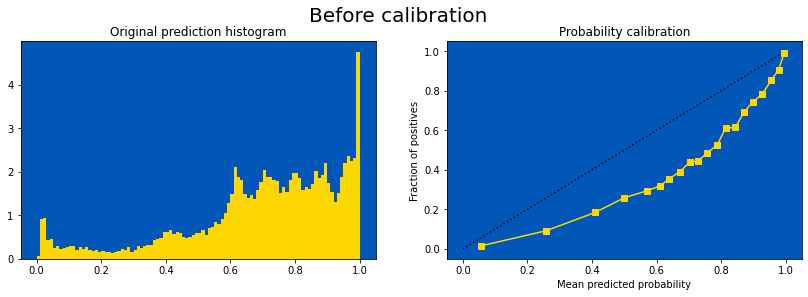

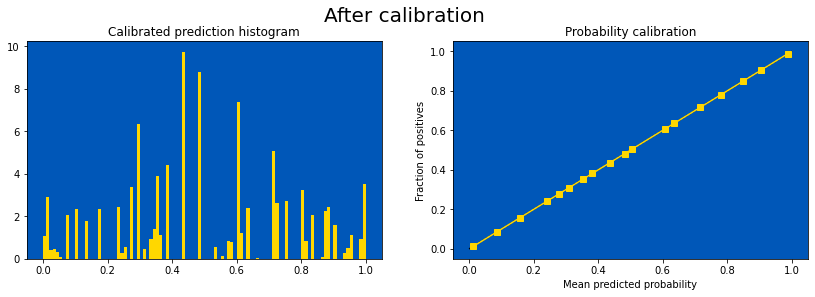

In [23]:
plot_oof_histogram('Original', X_dev[:,56], title='Before calibration')
plot_oof_histogram('Calibrated', 
                   IsotonicRegression(out_of_bounds='clip')
                   .fit_transform(X_dev[:,56], y)
                   .clip(0.001, 0.999),
                   title='After calibration')

The diagrams are somewhat misleading because they evaluate the isotonic regression model on the training data. To be convinced that the method is good, we need to cross-validate it like every other model.

Fold 0: log_loss = 0.52671
Fold 1: log_loss = 0.53508
Fold 2: log_loss = 0.52565
Fold 3: log_loss = 0.53152
Fold 4: log_loss = 0.52416
Average log_loss   56:  0.52862


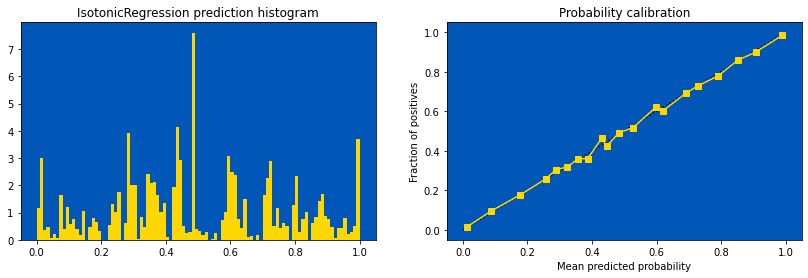

CPU times: user 1.24 s, sys: 901 ms, total: 2.14 s
Wall time: 1.91 s


In [24]:
%%time
sub = 56 # 0.6475577136.csv
score_list = []
oof = np.zeros((len(X_dev), ))
kf = StratifiedKFold(shuffle=True, random_state=1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
    X_tr = X_dev[idx_tr]
    X_va = X_dev[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]

    model = IsotonicRegression(out_of_bounds='clip')
    model.fit(X_tr[:,sub], y_tr)
    y_va_pred = model.predict(X_va[:,sub]).clip(0.001, 0.999)
    logloss = log_loss(y_va, y_va_pred)
    oof[idx_va] = y_va_pred
    print(f"Fold {fold}: log_loss = {logloss:.5f}")
    score_list.append(logloss)

print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss {sub:4}:  {sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}')
overall_score_df.loc['IsotonicRegression'] = (sum(score_list) / len(score_list), oof)
plot_oof_histogram('IsotonicRegression', oof)


# Blend of baseline models

We can create an ensemble of our baseline models (which are already ensembles). This time we use a simple average for blending. The blend does not include the `KNeighborsClassifier`, which is too weak.

Fold 0: log_loss = 0.52423
Fold 1: log_loss = 0.53548
Fold 2: log_loss = 0.52532
Fold 3: log_loss = 0.52828
Fold 4: log_loss = 0.52226
Average log_loss:  0.52711


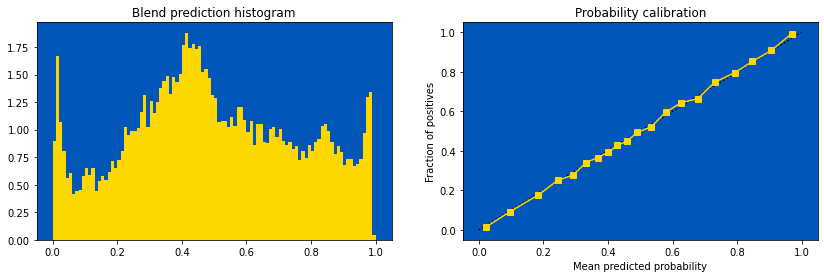

In [25]:
members = ['IsotonicRegression', 'MLPClassifier', 'ExtraTreesClassifier 0', 'ExtraTreesClassifier 1']
oof = np.column_stack(overall_score_df.oof.loc[members]).mean(axis=1)
score_list = []
kf = StratifiedKFold(shuffle=True, random_state=1)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_dev, y)):
    y_va = y[idx_va]
    logloss = log_loss(y_va, oof[idx_va])
    print(f"Fold {fold}: log_loss = {logloss:.5f}")
    score_list.append(logloss)
    
print(f'{Fore.GREEN}{Style.BRIGHT}Average log_loss:  {sum(score_list) / len(score_list):.5f}{Style.RESET_ALL}') # 0.54517
overall_score_df.loc[f'Blend of {len(members)} models'] = (sum(score_list) / len(score_list), oof)
plot_oof_histogram('Blend', oof)

# Model comparison

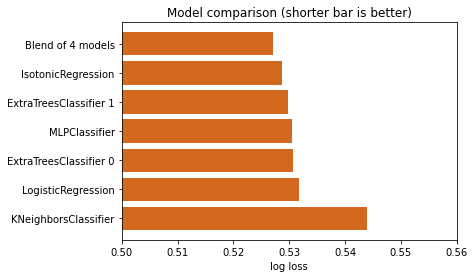

In [26]:
overall_score_df.sort_values('logloss', ascending=False, inplace=True)
plt.barh(np.arange(len(overall_score_df)), overall_score_df.logloss, color='chocolate')
plt.yticks(np.arange(len(overall_score_df)), overall_score_df.index)
plt.xlim(0.5, 0.56)
plt.title('Model comparison (shorter bar is better)')
plt.xlabel('log loss')
plt.show()

**Insight:**
- All five models are better than the best ensemble member (which has logloss 0.62).
- All five models predict well-calibrated probabilities.
- Of the single models, the calibrated `0.6475577136.csv` wins before `ExtraTreesClassifier` and `MLPClassifier`, `LogisticRegression` is fourth, `KNeighborsClassifier` ends up last.
- `ExtraTreeClassifier` has room for improvement if we increase `n_estimators`.
- The blend is better than all the single models. It is recommended that you develop several models for this competition and blend them for your final submission.
- All models have hyperparameters which need to be tuned. I haven't invested much time into tuning (yet).

Final words: I am sure that you will develop even better models 😊
